# Background Segmentation Experiments and Result Analysis for VTON Pipeline

## Sapiens

In [1]:
import os
import sys
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

sapiens_dir = "../Sapiens-Pytorch-Inference"

if not os.path.isdir(sapiens_dir):
    raise FileNotFoundError(f"Sapiens-Ordner nicht gefunden: {sapiens_dir}")

sys.path.insert(0, sapiens_dir)

from sapiens_inference import (
    SapiensDepth,
    SapiensDepthType,
    SapiensSegmentation,
    SapiensSegmentationType,
    SapiensConfig,
)


In [2]:

config = SapiensConfig()
config.depth_type = SapiensDepthType.DEPTH_1B
config.segmentation_type = SapiensSegmentationType.SEGMENTATION_1B

if torch.cuda.is_available():
    config.device = "cuda"
else:
    print("cpu")
    config.device = "cpu"

orig_cwd = os.getcwd()
try:
    os.makedirs(os.path.join(sapiens_dir, "models"), exist_ok=True)
    os.chdir(sapiens_dir)
    depth_predictor = SapiensDepth(config.depth_type, config.device, config.dtype)
    seg_predictor = SapiensSegmentation(config.segmentation_type, config.device, config.dtype)
finally:
    os.chdir(orig_cwd)

print("device", config.device)


device cpu


In [3]:


def run_sapiens_on_image(img_path):
    pil = Image.open(img_path).convert("RGB")
    rgb_np = np.array(pil)
    bgr_np = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2BGR)
    H, W = bgr_np.shape[:2]

    # Segmentation
    seg_logits = seg_predictor(bgr_np)
    if isinstance(seg_logits, torch.Tensor):
        seg_map = seg_logits.squeeze().cpu().numpy()
    else:
        seg_map = seg_logits

    if seg_map.shape != (H, W):
        seg_map = cv2.resize(seg_map, (W, H), interpolation=cv2.INTER_LINEAR)

    human_mask = (seg_map > 0.5).astype(np.uint8)

    return rgb_np, human_mask


Segmentation inference took: 74.8043 seconds


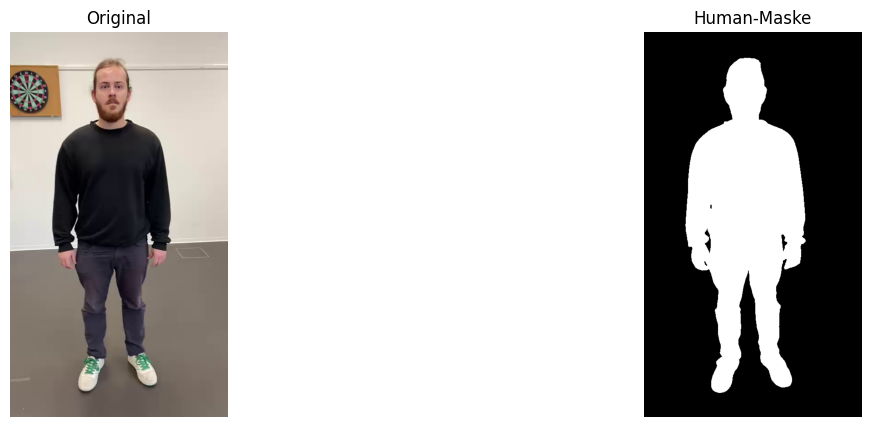

In [4]:
test_image = "../data/flo_16/real/images/florian_0000.jpg"

rgb, mask = run_sapiens_on_image(test_image)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Human-Maske")
plt.imshow(mask, cmap="gray")
plt.axis("off")



plt.show()


## SAM 3

In [ ]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image_url = "http://images.cocodataset.org/val2017/000000077595.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

# Segment using text prompt
inputs = processor(images=image, text="ear", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")
# Results contain:
# - masks: Binary masks resized to original image size
# - boxes: Bounding boxes in absolute pixel coordinates (xyxy format)
# - scores: Confidence scores


config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

C:\Users\can-e\PycharmProjects\bat\vton3d-bat\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\can-e\.cache\huggingface\hub\models--facebook--sam3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]